### Bot Detection using Digital DNA Compression

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
'''!unzip /content/genuine_accounts.csv.zip
!unzip /content/social_spambots_1.csv.zip
!unzip /content/social_spambots_2.csv.zip
!unzip /content/social_spambots_3.csv.zip
!unzip /content/social_spambots_4.csv.zip
!unzip /content/traditional_spambots_1.csv.zip
!unzip /content/traditional_spambots_2.csv.zip
!unzip /content/traditional_spambots_3.csv.zip
!unzip /content/traditional_spambots_4.csv.zip'''

'!unzip /content/genuine_accounts.csv.zip\n!unzip /content/social_spambots_1.csv.zip\n!unzip /content/social_spambots_2.csv.zip\n!unzip /content/social_spambots_3.csv.zip\n!unzip /content/social_spambots_4.csv.zip\n!unzip /content/traditional_spambots_1.csv.zip\n!unzip /content/traditional_spambots_2.csv.zip\n!unzip /content/traditional_spambots_3.csv.zip\n!unzip /content/traditional_spambots_4.csv.zip'

In [10]:
!cp "/content/drive/MyDrive/Cresci17/cresci-2017.csv.zip" "data.zip"

!unzip data.zip
!unzip /content/datasets_full.csv/crowdflower_results.csv.zip
!unzip /content/datasets_full.csv/fake_followers.csv.zip
!unzip /content/datasets_full.csv/genuine_accounts.csv.zip
!unzip /content/datasets_full.csv/social_spambots_1.csv.zip
!unzip /content/datasets_full.csv/social_spambots_2.csv.zip
!unzip /content/datasets_full.csv/social_spambots_3.csv.zip
!unzip /content/datasets_full.csv/social_spambots_4.csv.zip
!unzip /content/datasets_full.csv/traditional_spambots_1.csv.zip
!unzip /content/datasets_full.csv/traditional_spambots_2.csv.zip
!unzip /content/datasets_full.csv/traditional_spambots_3.csv.zip
!unzip /content/datasets_full.csv/traditional_spambots_4.csv.zip

Archive:  data.zip
   creating: datasets_full.csv/
  inflating: datasets_full.csv/crowdflower_results.csv.zip  
  inflating: datasets_full.csv/fake_followers.csv.zip  
  inflating: datasets_full.csv/genuine_accounts.csv.zip  
  inflating: datasets_full.csv/social_spambots_1.csv.zip  
  inflating: datasets_full.csv/social_spambots_2.csv.zip  
  inflating: datasets_full.csv/social_spambots_3.csv.zip  
  inflating: datasets_full.csv/traditional_spambots_1.csv.zip  
  inflating: datasets_full.csv/traditional_spambots_2.csv.zip  
  inflating: datasets_full.csv/traditional_spambots_3.csv.zip  
  inflating: datasets_full.csv/traditional_spambots_4.csv.zip  
  inflating: READ.ME                 
  inflating: datasets_full.csv/READ.ME  
Archive:  /content/datasets_full.csv/crowdflower_results.csv.zip
   creating: crowdflower_results.csv/
  inflating: crowdflower_results.csv/crowdflower_results_aggregated.csv  
   creating: __MACOSX/
   creating: __MACOSX/crowdflower_results.csv/
  inflating: __

In [11]:
import warnings
warnings.filterwarnings('ignore')

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

In [13]:
import random
import sys
import time
import zlib

In [14]:
from sklearn import utils
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, confusion_matrix
from scipy.stats import ttest_1samp

<hr>

### Digital DNA

Model account behaviour by defining the following alphabet, of cardinality N = 3,

$B^3_{type} = {\{A, C, T\}}$

A $\leftarrow$ tweet,

C $\leftarrow$ reply,

T $\leftarrow$ retweet

<hr>

#### Datasets

User profile data.

In [15]:
### Users

# Genuine accounts.
gen = pd.read_csv('/content/genuine_accounts.csv/users.csv')

# Social spambots.
ss1 = pd.read_csv('/content/social_spambots_1.csv/users.csv')
ss2 = pd.read_csv('/content/social_spambots_2.csv/users.csv')
ss3 = pd.read_csv('/content/social_spambots_3.csv/users.csv')

# Traditional spambots.
ts1 = pd.read_csv('/content/traditional_spambots_1.csv/users.csv')
ts2 = pd.read_csv('/content/traditional_spambots_2.csv/users.csv')
ts3 = pd.read_csv('/content/traditional_spambots_3.csv/users.csv')
ts4 = pd.read_csv('/content/traditional_spambots_4.csv/users.csv')

Tweets.

In [16]:
### Tweets

# Genuine accounts.
gen_tweets = pd.read_csv('/content/genuine_accounts.csv/tweets.csv', sep=",", encoding='Latin-1')

# Social spambots.
ss1_tweets = pd.read_csv('/content/social_spambots_1.csv/tweets.csv', sep=",", encoding='Latin-1')
ss2_tweets = pd.read_csv('/content/social_spambots_2.csv/tweets.csv', sep=",", encoding='Latin-1')
ss3_tweets = pd.read_csv('/content/social_spambots_3.csv/tweets.csv', sep=",", encoding='Latin-1')

# Traditional spambots.
ts1_tweets = pd.read_csv('/content/traditional_spambots_1.csv/tweets.csv', sep=",", encoding='Latin-1')

<hr>

#### Digital DNA.

In [18]:
gen_tweets.columns = ['id', 'text', 'source', 'user_id', 'truncated', 'in_reply_to_status_id', 'in_reply_to_user_id', 'in_reply_to_screen_name', 'retweeted_status_id', 'geo', 'place', 'contributors', 'retweet_count', 'reply_count', 'favorite_count', 'favorited', 'retweeted', 'possibly_sensitive', 'num_hashtags', 'num_urls', 'num_mentions', 'created_at', 'timestamp', 'crawled_at', 'updated']

In [19]:
print(gen_tweets['text'].head())

0    RT @morningJewshow: Speaking about Jews and co...
1    This age/face recognition thing..no reason pla...
2    Only upside of the moment I can think of is th...
3    If you're going to think about+create experien...
4    Watching a thread on FB about possible future ...
Name: text, dtype: object


In [20]:
def create_dna_from_tweets(tweets_df):
    '''For each user id in tweets_df return a digital DNA string based on posting behaviour.'''
    
    # Add columns for counts of tweets, replies and retweets.
    tweets_df['num_retweets'] = np.where(tweets_df['retweeted_status_id'] == 0, 0, 1)
    tweets_df['num_replies'] = np.where(tweets_df['in_reply_to_status_id'] == 0, 0, 1)
    tweets_df['num_tweets'] = np.where((tweets_df['num_retweets'] == 0) & (tweets_df['num_replies'] == 0), 1, 0)

    # DNA alphabet for tweet (A), retweet (C) and reply (T).
    tweets = tweets_df['num_tweets'] == 1
    retweets = tweets_df['num_retweets'] == 1
    replies = tweets_df['num_replies'] == 1

    tweets_df.loc[:, 'DNA'] = np.where(retweets, 'C', np.where(replies, 'T', 'A'))

    # Sort tweets by timestamp..
    tweets_df = tweets_df[['user_id', 'timestamp', 'DNA']]
    tweets_df = tweets_df.sort_values(by=['timestamp'])

    # Create digital DNA string for each user account.
    dna = tweets_df.groupby(by=['user_id'])['DNA'].agg(lambda x: ''.join(x))
    
    return dna

In [21]:
def create_dna_from_tweet_content(tweets_df):
  # Add columns for counts of tweets, replies and retweets.
    tweets_df['num_retweets'] = np.where(tweets_df['retweeted_status_id'] == 0, 0, 1)
    tweets_df['num_replies'] = np.where(tweets_df['in_reply_to_status_id'] == 0, 0, 1)
    tweets_df['num_tweets'] = np.where((tweets_df['num_retweets'] == 0) & (tweets_df['num_replies'] == 0), 1, 0)

    # DNA alphabet for tweet (A), retweet (C) and reply (T).
    tweets = tweets_df['num_tweets'] == 1
    retweets = tweets_df['num_retweets'] == 1
    replies = tweets_df['num_replies'] == 1

    tweets_df.loc[:, 'DNA'] = np.where(retweets, 'C', np.where(replies, 'T', 'A'))
    tweets_df.loc[:, 'new_DNA'] = np.where(tweets_df['num_hashtags'] == 1 , tweets_df['DNA'] + 'H', tweets_df['DNA'])
    # Sort tweets by timestamp..
    tweets_df = tweets_df[['user_id', 'timestamp', 'DNA', 'new_DNA']]
    tweets_df = tweets_df.sort_values(by=['timestamp'])

    # Create digital DNA string for each user account.
    dna = tweets_df.groupby(by=['user_id'])['new_DNA'].agg(lambda x: ''.join(x))
    
    return dna

In [22]:
def compress_dna_df(dna):
    '''Return a dataframe with compression facts for a series of dna.'''

    # Convert DNA in string object to bytes object.
    dna_bytes = dna.apply(lambda s: s.encode('utf-8'))

    # Run compression on each DNA string in the sample.
    dna_compressed = dna_bytes.apply(lambda b: zlib.compress(b))

    # Create dataframe with compression facts.
    dna_df = pd.DataFrame({'dna': dna,
                           'original_dna_size': dna_bytes.apply(sys.getsizeof), 
                           'compressed_dna_size': dna_compressed.apply(sys.getsizeof)})
    
    dna_df['compression_ratio'] = dna_df['original_dna_size'] / dna_df['compressed_dna_size']
    
    return dna_df

<hr>

Create DNA strings based on behaviour activity for each account.

In [23]:
gen_tweets['num_hashtags'].value_counts()

0.0     2388931
1.0      306535
2.0       90481
3.0       29026
4.0       11943
5.0        5101
6.0        2755
7.0        1709
8.0        1173
9.0         756
10.0        430
11.0        252
12.0        114
13.0         55
14.0         42
15.0         20
16.0         15
17.0          6
18.0          4
20.0          3
23.0          2
28.0          2
21.0          1
27.0          1
24.0          1
25.0          1
22.0          1
19.0          1
Name: num_hashtags, dtype: int64

In [24]:
gen_dna = create_dna_from_tweet_content(gen_tweets)
ss1_dna = create_dna_from_tweet_content(ss1_tweets)
ss2_dna = create_dna_from_tweet_content(ss2_tweets)
ss3_dna = create_dna_from_tweet_content(ss3_tweets)

ts1_dna = create_dna_from_tweet_content(ts1_tweets)

Compression on digital DNA strings.

In [25]:
gen_dna = compress_dna_df(gen_dna)

ss1_dna = compress_dna_df(ss1_dna)
ss2_dna = compress_dna_df(ss2_dna)
ss3_dna = compress_dna_df(ss3_dna)

ts1_dna = compress_dna_df(ts1_dna)

bot_dna = pd.concat([ss1_dna, ss2_dna, ss3_dna])

<hr>

#### Visualise compression facts for accounts.

In [26]:
# Add a column for account type to the dataframes.
gen_dna['Account Type'] = 'Genuine'
bot_dna['Account Type'] = 'Bot'

# Combine all samples into a single dataframe.
all_dna = pd.concat([gen_dna, bot_dna])

In [27]:
all_dna.sample(5)

,dna,original_dna_size,compressed_dna_size,compression_ratio,Account Type
user_id,,,,,
2.277236e+09,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAHAAAAAAA...,1853,172,10.773256,Bot
2.355046e+09,AAAAAAAAAHAAAAAAAATAATAATAATAATAATAATAAAAATAAA...,171,77,2.220779,Bot
2.351059e+09,AHAAAAAAAAAAAAAAAAAAAAATAATAATTAATAATTAATAATAA...,165,67,2.462687,Bot
2.377879e+09,AAAATAHATHAATATAATAAHTATAAHTAATAAHTAATAATHATAA...,143,84,1.702381,Bot
2.357706e+09,AAAAAAHTAATAATAAAAAAAAAAATAATAATAHATAAAHAATAAA...,142,77,1.844156,Bot


##### Plot of Uncompressed DNA Size vs. Compressed DNA Size.

Includes the following accounts:
1. Genuine users
1. Social Spambots \#1
1. Social Spambots \#2
1. Social Spambots \#3
1. Traditional Spambots \#1

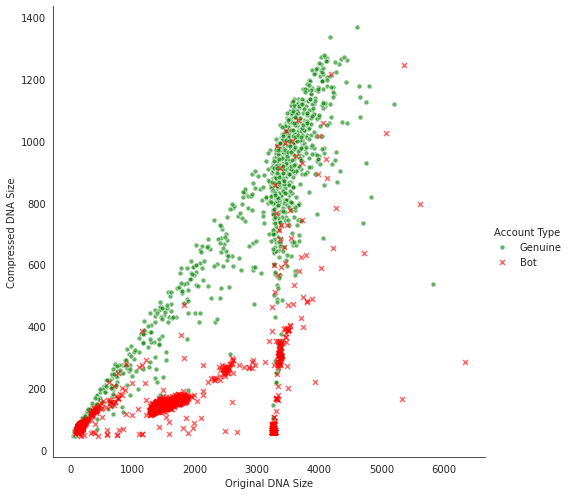

In [28]:
sns.set_style("white")

pal = {
    'Genuine': 'green',
    'Bot': 'red'
}

g = sns.FacetGrid(all_dna, hue='Account Type', palette=pal, size=7, hue_kws=dict(marker=["o", "x"]))
g.map(plt.scatter, "original_dna_size", "compressed_dna_size", s=25, alpha=.6, edgecolor="white")
g.add_legend()
g.set_axis_labels('Original DNA Size', 'Compressed DNA Size')

##### Plot of DNA Size vs. Compression Ratio.

Includes the following accounts:
1. Genuine users
1. Social Spambots \#1
1. Social Spambots \#2
1. Social Spambots \#3
1. Traditional Spambots \#1

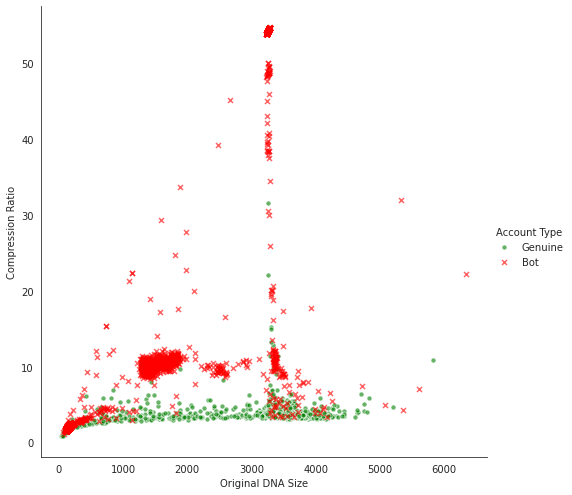

In [29]:
sns.set_style("white")

pal = {
    'Genuine': 'green',
    'Bot': 'red'
}

g = sns.FacetGrid(all_dna, hue='Account Type', palette=pal, size=7, hue_kws=dict(marker=["o", "x"]))
g.map(plt.scatter, "original_dna_size", "compression_ratio", s=25, alpha=.6, edgecolor="white")
g.add_legend()
g.set_axis_labels('Original DNA Size', 'Compression Ratio')

##### Historgram for Compression Ratio

Includes the following accounts:
1. Genuine users
1. Social Spambots \#1
1. Social Spambots \#2
1. Social Spambots \#3
1. Traditional Spambots \#1

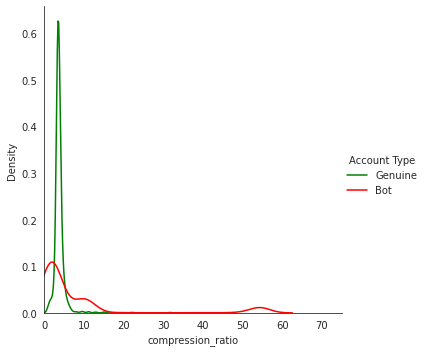

In [30]:
g = sns.FacetGrid(all_dna, hue='Account Type', palette=pal, size=5)
g.set(xlim=(0, 75))
g.map(sns.kdeplot, 'compression_ratio')
g.add_legend()

<hr>

Evaluation Metrics
1. Accuracy
1. Precision
1. Recall
1. F1 Score
1. Specificity
1. MCC

In [31]:
def evaluate(y_test, predictions):
    '''Return a dataframe with accuracy, precision, recall and f1 scores for predictions.'''
    
    tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
    specificity = tn / (tn+fp)
    
    results = [
        {
            'Metric': 'Accuracy',
            'Score': accuracy_score(y_test, predictions)
        },
        {
            'Metric': 'Precision',
            'Score': precision_score(y_test, predictions)
        },
        {
            'Metric': 'Recall',
            'Score': recall_score(y_test, predictions)
        },
        {
            'Metric': 'F1 Score',
            'Score': f1_score(y_test, predictions)
        },
        {
            'Metric': 'MCC',
            'Score': matthews_corrcoef(y_test, predictions)
        },
        {
            'Metric': 'Specificity',
            'Score': specificity
        },
    ]

    return pd.DataFrame(results)

<hr>

In [32]:
def train_predict_evaluate(dna, features, test_size=0.5):
    '''Train a Logistic Regression model with given features
    using default parameters on a random sample of data.'''

    # Randomly shuffle the dna dataframe.
    dna = utils.shuffle(dna)

    # Features and labels.
    X = dna[features]
    y = dna.loc[:, 'label']

    # Split the dataset for training and testing using Logistic Regression.
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)

    # Logistic Regression classifier with default parameters.
    classifier = LogisticRegression()

    # Train the classifier.
    start_train = time.time()
    classifier.fit(X_train, y_train)
    end_train = time.time()

    # Make predictions on the test set.
    start_test = time.time()
    predictions = classifier.predict(X_test)
    end_test = time.time()

    # Evaluation on the test set.
    results = evaluate(y_test, predictions)

    return results

<hr>

Results for k-common substring

In [33]:
k_common_substring_1 = pd.DataFrame({'Supervised': [0.977, 0.977, 0.955, 0.982, 0.977, 0.981],
                                     'Unsupervised': [0.976, 0.977, 0.952, 0.982, 0.972, 0.981]}, 
                                    index=['Accuracy', 'F1 Score', 'MCC', 'Precision', 'Recall', 'Specificity'])


In [34]:
k_common_substring_2 = pd.DataFrame({'Supervised': [0.970, 0.970, 0.940, 0.978, 0.961, 0.979], 
                                     'Unsupervised': [0.929, 0.923, 0.867, 1.000, 0.858, 1.000]},
                                    index=['Accuracy', 'F1 Score', 'MCC', 'Precision', 'Recall', 'Specificity'])

<hr>

## Test Set #1

In [35]:
# Genuine accounts in test set 1.
gen_test1 = gen[gen['test_set_1'] == 1]

# Social spambots in test set 1.
ss1_test_1 = ss1[ss1['test_set_1'] == 1]


# Tweets for genuine accounts in test set 1.
gen_tweets_test1 = gen_tweets[gen_tweets['user_id'].isin(gen_test1['id'])]

# Tweets for spambot accounts in test set 1.
ss1_tweets_test1 = ss1_tweets[ss1_tweets['user_id'].isin(ss1_test_1['id'])]


# DNA for genuine accounts in test set 1.
gen_dna_test1 = create_dna_from_tweet_content(gen_tweets_test1)

# DNA for spambots in test set 1.
ss1_dna_test1 = create_dna_from_tweet_content(ss1_tweets_test1)


# DNA string compression for genuine accounts in test set 1.
gen_dna_test1 = compress_dna_df(gen_dna_test1)

# DNA string compression for spambots in test set 1.
ss1_dna_test1 = compress_dna_df(ss1_dna_test1)


# Add a column for label to the dataframes.
gen_dna_test1['label'] = 0
ss1_dna_test1['label'] = 1

There are some accounts for which there are no tweets, set an empty string as the DNA sequence for such accounts.

In [36]:
sys.getsizeof(''.encode('utf-8'))   # size in bytes of empty string

33

In [37]:
sys.getsizeof(zlib.compress(''.encode('utf-8')))    # size in bytes of compressed empty string

41

In [38]:
# compression ratio for empty string
sys.getsizeof(''.encode('utf-8')) / sys.getsizeof(zlib.compress(''.encode('utf-8')))

0.8048780487804879

In [39]:
gen_with_no_tweets_test1 = gen_test1[~gen_test1['id'].isin(gen_dna_test1.index)]

gen_with_no_tweets_dna_test1 = pd.DataFrame({'id': gen_with_no_tweets_test1['id'], 
                                             'original_dna_size': 33, 
                                             'compressed_dna_size': 41, 
                                             'compression_ratio': 0.80, 
                                             'label': 0})

gen_with_no_tweets_dna_test1 = gen_with_no_tweets_dna_test1.set_index('id')

gen_dna_test1 = pd.concat([gen_dna_test1, gen_with_no_tweets_dna_test1])

# Combine test set 1 accounts into a single dataframe.
dna_test1 = pd.concat([gen_dna_test1, ss1_dna_test1])

In [40]:
dna_test1.sample(5)

,dna,original_dna_size,compressed_dna_size,compression_ratio,label
3.022544e+09,NaN,33,41,0.800000,0
4.671142e+08,AAAHAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...,1456,147,9.904762,1
4.129826e+08,NaN,33,41,0.800000,0
8.367425e+08,NaN,33,41,0.800000,0
4.662893e+08,AAAAAAAAAAAAAAAAAAAAAHAHAAAAAAAAAAAAAAAAAAAAAA...,1386,141,9.829787,1


1. Logistic Regression with Original DNA Size + Compressed DNA Size

In [41]:
results = pd.DataFrame()

for i in range(1000):
    np.random.seed(i)
    results = pd.concat([results, train_predict_evaluate(dna_test1, ['original_dna_size', 'compressed_dna_size'])])

# Compute average scores for each metric
results_with_length = results.groupby(by=['Metric']) \
               .mean() \
               .rename({'Score': 'Mean'}, axis=1) \
               .join(results.groupby(by=['Metric'])
                            .std() \
                            .rename({'Score': 'Std.'}, axis=1))

# Compute statistical significance against the method k-common-substring for DNA sequences
stat_sig = []
for metric in k_common_substring_1.index:
    s = dict()

    ts, ps = ttest_1samp(results[results['Metric'] == metric]['Score'], 
                         k_common_substring_1['Supervised'][metric])
    tu, pu = ttest_1samp(results[results['Metric'] == metric]['Score'], 
                         k_common_substring_1['Unsupervised'][metric])

    s['Metric'] = metric
    s['t-supervised'] = round(ts, 4)
    s['t-unsupervised'] = round(tu, 4)
    s['p-supervised'] = round(ps, 4)
    s['p-unsupervised'] = round(pu, 4)
    s['Mean'] = results[results['Metric'] == metric]['Score'].mean()
    s['SD'] = results[results['Metric'] == metric]['Score'].std()
    s['k-supervised'] = k_common_substring_1['Supervised'][metric]
    s['k-unsupervised'] = k_common_substring_1['Unsupervised'][metric]
    
    stat_sig.append(s)

stat_sig = pd.DataFrame(stat_sig).set_index(['Metric'])

stat_sig

,t-supervised,t-unsupervised,p-supervised,p-unsupervised,Mean,SD,k-supervised,k-unsupervised
Metric,,,,,,,,
Accuracy,42.2406,51.6970,0.0,0.0,0.981467,0.003344,0.977,0.976
F1 Score,41.8258,41.8258,0.0,0.0,0.981426,0.003346,0.977,0.977
MCC,37.9686,52.2394,0.0,0.0,0.962982,0.006648,0.955,0.952
Precision,-13.0601,-13.0601,0.0,0.0,0.979013,0.007233,0.982,0.982
Recall,46.2792,79.7928,0.0,0.0,0.983905,0.004718,0.977,0.972
Specificity,-8.3826,-8.3826,0.0,0.0,0.979058,0.007327,0.981,0.981


2. Logistic Regression with Original DNA Size + Compression Ratio

In [42]:
results = pd.DataFrame()
for i in range(1000):
    np.random.seed(i)
    results = pd.concat([results, train_predict_evaluate(dna_test1, ['original_dna_size', 'compression_ratio'])])

# Compute average scores for each metric
results_with_ratio = results.groupby(by=['Metric']) \
               .mean() \
               .rename({'Score': 'Mean'}, axis=1) \
               .join(results.groupby(by=['Metric'])
                            .std() \
                            .rename({'Score': 'Std.'}, axis=1))

# Compute statistical significance against the method k-common-substring for DNA sequences
stat_sig = []
for metric in k_common_substring_1.index:
    s = dict()

    ts, ps = ttest_1samp(results[results['Metric'] == metric]['Score'], 
                         k_common_substring_1['Supervised'][metric])
    tu, pu = ttest_1samp(results[results['Metric'] == metric]['Score'], 
                         k_common_substring_1['Unsupervised'][metric])

    s['Metric'] = metric
    s['t-supervised'] = round(ts, 4)
    s['t-unsupervised'] = round(tu, 4)
    s['p-supervised'] = round(ps, 4)
    s['p-unsupervised'] = round(pu, 4)
    s['Mean'] = results[results['Metric'] == metric]['Score'].mean()
    s['SD'] = results[results['Metric'] == metric]['Score'].std()
    s['k-supervised'] = k_common_substring_1['Supervised'][metric]
    s['k-unsupervised'] = k_common_substring_1['Unsupervised'][metric]
    
    stat_sig.append(s)

stat_sig = pd.DataFrame(stat_sig).set_index(['Metric'])

stat_sig

,t-supervised,t-unsupervised,p-supervised,p-unsupervised,Mean,SD,k-supervised,k-unsupervised
Metric,,,,,,,,
Accuracy,60.4275,71.2561,0.0,0.0,0.982580,0.002920,0.977,0.976
F1 Score,57.1912,57.1912,0.0,0.0,0.982409,0.002991,0.977,0.977
MCC,55.3928,71.6675,0.0,0.0,0.965211,0.005829,0.955,0.952
Precision,35.1227,35.1227,0.0,0.0,0.986930,0.004439,0.982,0.982
Recall,5.7718,35.8324,0.0,0.0,0.977960,0.005260,0.977,0.972
Specificity,44.3132,44.3132,0.0,0.0,0.987157,0.004394,0.981,0.981


In [43]:
print('String Compression - Compressed DNA Size &',
      '{:.3f} &'.format(results_with_length['Mean']['Accuracy']),
      '{:.3f} &'.format(results_with_length['Mean']['Precision']),
      '{:.3f} &'.format(results_with_length['Mean']['Recall']),
      '{:.3f} &'.format(results_with_length['Mean']['F1 Score']),
      '{:.3f} &'.format(results_with_length['Mean']['MCC']),
      '{:.3f} \\\\'.format(results_with_length['Mean']['Specificity']))

print('String Compression - Compression Ratio &',
      '{:.3f} &'.format(results_with_ratio['Mean']['Accuracy']),
      '{:.3f} &'.format(results_with_ratio['Mean']['Precision']),
      '{:.3f} &'.format(results_with_ratio['Mean']['Recall']),
      '{:.3f} &'.format(results_with_ratio['Mean']['F1 Score']),
      '{:.3f} &'.format(results_with_ratio['Mean']['MCC']),
      '{:.3f} \\\\'.format(results_with_ratio['Mean']['Specificity']))

String Compression - Compressed DNA Size & 0.981 & 0.979 & 0.984 & 0.981 & 0.963 & 0.979 \\
String Compression - Compression Ratio & 0.983 & 0.987 & 0.978 & 0.982 & 0.965 & 0.987 \\


<hr>

## Test Set #2

In [44]:
# Genuine accounts in test set 2.
gen_test2 = gen[gen['test_set_2'] == 1]

# Social spambots in test set 2.
ss3_test_2 = ss3[ss3['test_set_2'] == 1]


# Tweets for genuine accounts in test set 2.
gen_tweets_test2 = gen_tweets[gen_tweets['user_id'].isin(gen_test2['id'])]

# Tweets for spambot accounts in test set 2.
ss3_tweets_test2 = ss3_tweets[ss3_tweets['user_id'].isin(ss3_test_2['id'])]


# DNA for genuine accounts in test set 2.
gen_dna_test2 = create_dna_from_tweets(gen_tweets_test2)

# DNA for spambots in test set 2.
ss3_dna_test2 = create_dna_from_tweets(ss3_tweets_test2)


# DNA string compression for genuine accounts in test set 2.
gen_dna_test2 = compress_dna_df(gen_dna_test2)

# DNA string compression for spambots in test set 2.
ss3_dna_test2 = compress_dna_df(ss3_dna_test2)


# Add a column for label to the dataframes.
gen_dna_test2['label'] = 0
ss3_dna_test2['label'] = 1


# Combine test set 2 accounts into a single dataframe.
dna_test2 = pd.concat([gen_dna_test2, ss3_dna_test2])

In [45]:
gen_with_no_tweets_test2 = gen_test2[~gen_test2['id'].isin(gen_dna_test2.index)]

gen_with_no_tweets_dna_test2 = pd.DataFrame({'id': gen_with_no_tweets_test2['id'], 
                                             'original_dna_size': 33, 
                                             'compressed_dna_size': 41, 
                                             'compression_ratio': 0.80, 
                                             'label': 0})

gen_with_no_tweets_dna_test2 = gen_with_no_tweets_dna_test2.set_index('id')

gen_dna_test2 = pd.concat([gen_dna_test2, gen_with_no_tweets_dna_test2])

# Combine test set 1 accounts into a single dataframe.
dna_test2 = pd.concat([gen_dna_test2, ss3_dna_test2])

1. Logistic Regression with Original DNA Size + Compressed DNA Size

In [46]:
results = pd.DataFrame()

for i in range(1000):
    np.random.seed(i)
    results = pd.concat([results, train_predict_evaluate(dna_test2, ['original_dna_size', 'compressed_dna_size'])])

results_with_length = results.groupby(by=['Metric']) \
                           .mean() \
                           .rename({'Score': 'Mean'}, axis=1) \
                           .join(results.groupby(by=['Metric'])
                                        .std() \
                                        .rename({'Score': 'Std.'}, axis=1))
# Compute average scores for each metric
results_with_length = results.groupby(by=['Metric']) \
               .mean() \
               .rename({'Score': 'Mean'}, axis=1) \
               .join(results.groupby(by=['Metric'])
                            .std() \
                            .rename({'Score': 'Std.'}, axis=1))

# Compute statistical significance against the method k-common-substring for DNA sequences
stat_sig = []
for metric in k_common_substring_2.index:
    s = dict()

    ts, ps = ttest_1samp(results[results['Metric'] == metric]['Score'], 
                         k_common_substring_2['Supervised'][metric])
    tu, pu = ttest_1samp(results[results['Metric'] == metric]['Score'], 
                         k_common_substring_2['Unsupervised'][metric])

    s['Metric'] = metric
    s['t-supervised'] = round(ts, 4)
    s['t-unsupervised'] = round(tu, 4)
    s['p-supervised'] = round(ps, 4)
    s['p-unsupervised'] = round(pu, 4)
    s['Mean'] = results[results['Metric'] == metric]['Score'].mean()
    s['SD'] = results[results['Metric'] == metric]['Score'].std()
    s['k-supervised'] = k_common_substring_2['Supervised'][metric]
    s['k-unsupervised'] = k_common_substring_2['Unsupervised'][metric]
    
    stat_sig.append(s)

stat_sig = pd.DataFrame(stat_sig).set_index(['Metric'])

stat_sig

,t-supervised,t-unsupervised,p-supervised,p-unsupervised,Mean,SD,k-supervised,k-unsupervised
Metric,,,,,,,,
Accuracy,-22.7424,186.7595,0.0,0.0,0.965549,0.006189,0.970,0.929
F1 Score,-29.5854,196.9401,0.0,0.0,0.963862,0.006561,0.970,0.923
MCC,-21.5924,167.4248,0.0,0.0,0.931661,0.012213,0.940,0.867
Precision,13.9334,-56.7854,0.0,0.0,0.982335,0.009838,0.978,1.000
Recall,-37.8627,226.3054,0.0,0.0,0.946237,0.012330,0.961,0.858
Specificity,16.8315,-56.0353,0.0,0.0,0.983851,0.009114,0.979,1.000


2. Logistic Regression with Original DNA Size + Compression Ratio

In [47]:
results = pd.DataFrame()
for i in range(1000):
    np.random.seed(i)
    results = pd.concat([results, train_predict_evaluate(dna_test2, ['original_dna_size', 'compression_ratio'])])

# Compute average scores for each metric
results_with_ratio = results.groupby(by=['Metric']) \
               .mean() \
               .rename({'Score': 'Mean'}, axis=1) \
               .join(results.groupby(by=['Metric'])
                            .std() \
                            .rename({'Score': 'Std.'}, axis=1))

# Compute statistical significance against the method k-common-substring for DNA sequences
stat_sig = []
for metric in k_common_substring_2.index:
    s = dict()

    ts, ps = ttest_1samp(results[results['Metric'] == metric]['Score'], 
                         k_common_substring_2['Supervised'][metric])
    tu, pu = ttest_1samp(results[results['Metric'] == metric]['Score'], 
                         k_common_substring_2['Unsupervised'][metric])

    s['Metric'] = metric
    s['t-supervised'] = round(ts, 4)
    s['t-unsupervised'] = round(tu, 4)
    s['p-supervised'] = round(ps, 4)
    s['p-unsupervised'] = round(pu, 4)
    s['Mean'] = results[results['Metric'] == metric]['Score'].mean()
    s['SD'] = results[results['Metric'] == metric]['Score'].std()
    s['k-supervised'] = k_common_substring_2['Supervised'][metric]
    s['k-unsupervised'] = k_common_substring_2['Unsupervised'][metric]
    
    stat_sig.append(s)

stat_sig = pd.DataFrame(stat_sig).set_index(['Metric'])

stat_sig

,t-supervised,t-unsupervised,p-supervised,p-unsupervised,Mean,SD,k-supervised,k-unsupervised
Metric,,,,,,,,
Accuracy,44.0582,285.6866,0.0,0.0,0.977476,0.005366,0.970,0.929
F1 Score,36.4846,300.0958,0.0,0.0,0.976505,0.005638,0.970,0.923
MCC,45.7739,264.7409,0.0,0.0,0.955260,0.010543,0.940,0.867
Precision,44.2840,-41.6268,0.0,0.0,0.989340,0.008098,0.978,1.000
Recall,8.6702,293.5504,0.0,0.0,0.964135,0.011433,0.961,0.858
Specificity,45.9728,-40.9229,0.0,0.0,0.990110,0.007642,0.979,1.000


In [48]:
print('String Compression - Compressed DNA Size &',
      '{:.3f} &'.format(results_with_length['Mean']['Accuracy']),
      '{:.3f} &'.format(results_with_length['Mean']['Precision']),
      '{:.3f} &'.format(results_with_length['Mean']['Recall']),
      '{:.3f} &'.format(results_with_length['Mean']['F1 Score']),
      '{:.3f} &'.format(results_with_length['Mean']['MCC']),
      '{:.3f} \\\\'.format(results_with_length['Mean']['Specificity']))

print('String Compression - Compression Ratio &',
      '{:.3f} &'.format(results_with_ratio['Mean']['Accuracy']),
      '{:.3f} &'.format(results_with_ratio['Mean']['Precision']),
      '{:.3f} &'.format(results_with_ratio['Mean']['Recall']),
      '{:.3f} &'.format(results_with_ratio['Mean']['F1 Score']),
      '{:.3f} &'.format(results_with_ratio['Mean']['MCC']),
      '{:.3f} \\\\'.format(results_with_ratio['Mean']['Specificity']))

String Compression - Compressed DNA Size & 0.966 & 0.982 & 0.946 & 0.964 & 0.932 & 0.984 \\
String Compression - Compression Ratio & 0.977 & 0.989 & 0.964 & 0.977 & 0.955 & 0.990 \\


<hr>

#### Compression Statistics over the test sets

In [49]:
# Filter genuine accounts and bot accounts to compute statistics for each group.
g = all_dna['Account Type'] == 'Genuine'
b = all_dna['Account Type'] == 'Bot'

In [50]:
compression_stats = pd.DataFrame({'Mean Length': [all_dna['dna'].apply(len).mean(), 
                                                  all_dna[g]['dna'].apply(len).mean(), 
                                                  all_dna[b]['dna'].apply(len).mean()],
                                  'SD Length': [all_dna['dna'].apply(len).std(), 
                                                all_dna[g]['dna'].apply(len).std(), 
                                                all_dna[b]['dna'].apply(len).std()],
                                  'Mean Uncompressed Size': [all_dna['original_dna_size'].mean(), 
                                                             all_dna[g]['original_dna_size'].mean(), 
                                                             all_dna[b]['original_dna_size'].mean()],
                                  'SD Uncompressed Size': [all_dna['original_dna_size'].std(), 
                                                            all_dna[g]['original_dna_size'].std(), 
                                                           all_dna[b]['original_dna_size'].std()],
                                  'Mean Compressed Size': [all_dna['compressed_dna_size'].mean(), 
                                                           all_dna[g]['compressed_dna_size'].mean(), 
                                                           all_dna[b]['compressed_dna_size'].mean()],
                                  'SD Compressed Size': [all_dna['compressed_dna_size'].std(), 
                                                         all_dna[g]['compressed_dna_size'].std(), 
                                                         all_dna[b]['compressed_dna_size'].std()],
                                  'Mean Compressio Ratio': [all_dna['compression_ratio'].mean(), 
                                                            all_dna[g]['compression_ratio'].mean(), 
                                                            all_dna[b]['compression_ratio'].mean()],
                                  'SD Compressio Ratio': [all_dna['compression_ratio'].std(), 
                                                          all_dna[g]['compression_ratio'].std(), 
                                                          all_dna[b]['compression_ratio'].std()]},
                                 index=['All', 'Genuine', 'Bot'])

In [51]:
compression_stats

,Mean Length,SD Length,Mean Uncompressed Size,SD Uncompressed Size,Mean Compressed Size,SD Compressed Size,Mean Compressio Ratio,SD Compressio Ratio
All,1120.022686,1362.236321,1153.022686,1362.236321,221.541952,301.711849,7.246384,12.896401
Genuine,2904.797784,1128.804096,2937.797784,1128.804096,776.917821,311.351626,3.827995,1.530755
Bot,726.514658,1061.524330,759.514658,1061.524330,99.092427,82.037925,8.000072,14.118532


In [52]:
print('All &',
      '{:.2f} & '.format(compression_stats['Mean Length']['All']),
      '{:.2f} & '.format(compression_stats['SD Length']['All']),
      '{:.2f} & '.format(compression_stats['Mean Uncompressed Size']['All']),
      '{:.2f} & '.format(compression_stats['SD Uncompressed Size']['All']),
      '{:.2f} & '.format(compression_stats['Mean Compressed Size']['All']),
      '{:.2f} & '.format(compression_stats['SD Compressed Size']['All']),
      '{:.2f} & '.format(compression_stats['Mean Compressio Ratio']['All']),
      '{:.2f} \\\\ '.format(compression_stats['SD Compressio Ratio']['All']),
     )

print('Genuine &',
      '{:.2f} & '.format(compression_stats['Mean Length']['Genuine']),
      '{:.2f} & '.format(compression_stats['SD Length']['Genuine']),
      '{:.2f} & '.format(compression_stats['Mean Uncompressed Size']['Genuine']),
      '{:.2f} & '.format(compression_stats['SD Uncompressed Size']['Genuine']),
      '{:.2f} & '.format(compression_stats['Mean Compressed Size']['Genuine']),
      '{:.2f} & '.format(compression_stats['SD Compressed Size']['Genuine']),
      '{:.2f} & '.format(compression_stats['Mean Compressio Ratio']['Genuine']),
      '{:.2f} \\\\ '.format(compression_stats['SD Compressio Ratio']['Genuine']),
     )

print('Bot &',
      '{:.2f} & '.format(compression_stats['Mean Length']['Bot']),
      '{:.2f} & '.format(compression_stats['SD Length']['Bot']),
      '{:.2f} & '.format(compression_stats['Mean Uncompressed Size']['Bot']),
      '{:.2f} & '.format(compression_stats['SD Uncompressed Size']['Bot']),
      '{:.2f} & '.format(compression_stats['Mean Compressed Size']['Bot']),
      '{:.2f} & '.format(compression_stats['SD Compressed Size']['Bot']),
      '{:.2f} & '.format(compression_stats['Mean Compressio Ratio']['Bot']),
      '{:.2f} \\\\ '.format(compression_stats['SD Compressio Ratio']['Bot']),
     )

All & 1120.02 &  1362.24 &  1153.02 &  1362.24 &  221.54 &  301.71 &  7.25 &  12.90 \\ 
Genuine & 2904.80 &  1128.80 &  2937.80 &  1128.80 &  776.92 &  311.35 &  3.83 &  1.53 \\ 
Bot & 726.51 &  1061.52 &  759.51 &  1061.52 &  99.09 &  82.04 &  8.00 &  14.12 \\ 


#### Histogram of compression ratio

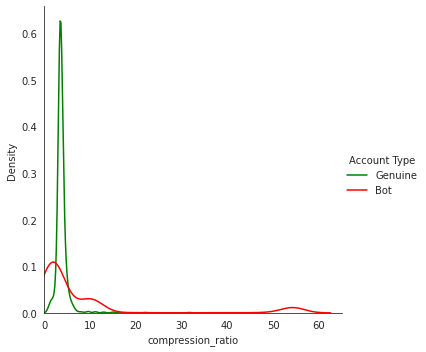

In [53]:
g = sns.FacetGrid(all_dna, hue='Account Type', palette=pal, height=5)
g.set(xlim=(0, 65))
g.map(sns.kdeplot, 'compression_ratio')
g.add_legend()

#### Boxplot of compression ratio

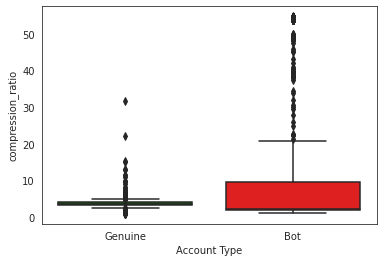

In [54]:
sns.boxplot(data=all_dna, x='Account Type', y='compression_ratio', palette=pal, orient='v')

<hr>

##### Plot of Uncompressed DNA Size vs. Compressed DNA Size.

Includes the following accounts:
1. Genuine users
1. Social Spambots \#1
1. Social Spambots \#3

findfont: Font family ['Source Sans Pro'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Source Sans Pro'] not found. Falling back to DejaVu Sans.


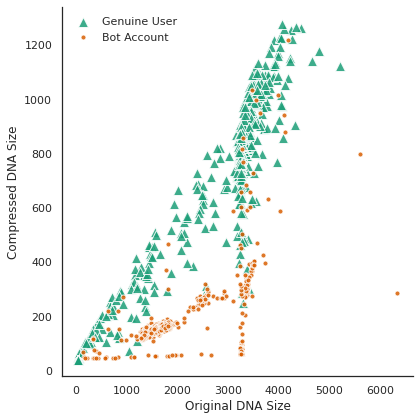

In [55]:
dna_all = pd.concat([dna_test1, dna_test2]).rename({'label': 'Account Type'}, axis=1)
dna_all['Account Type'] = np.where(dna_all['Account Type'] == 0, 'Genuine User', 'Bot Account')

sns.set(style='white', font='Source Sans Pro')

pal = {
    'Genuine User': sns.color_palette('Dark2')[0],
    'Bot Account':  sns.color_palette('Dark2')[1]
}

g = sns.FacetGrid(dna_all, hue='Account Type', 
                  palette=pal, height=6, hue_kws=dict(marker=["^", "."]))
g.map(plt.scatter, "original_dna_size", "compressed_dna_size", s=100, alpha=0.85, edgecolor="white")
# g.add_legend()
plt.legend(loc='upper left', frameon=False)
g.set_axis_labels('Original DNA Size', 'Compressed DNA Size')
g.savefig('dna-scatter-1.pdf')

##### Plot of DNA Size vs. Compression Ratio.

Includes the following accounts:
1. Genuine users
1. Social Spambots \#1
1. Social Spambots \#3

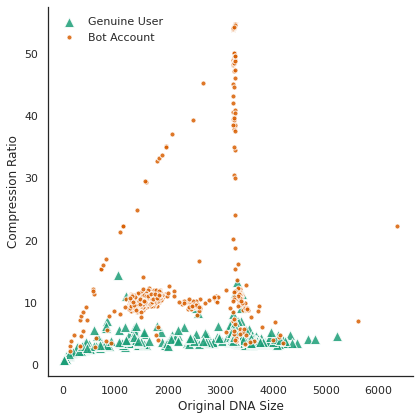

In [56]:
dna_all = pd.concat([dna_test1, dna_test2]).rename({'label': 'Account Type'}, axis=1)
dna_all['Account Type'] = np.where(dna_all['Account Type'] == 0, 'Genuine User', 'Bot Account')

sns.set(style='white', font='Source Sans Pro')

pal = {
    'Genuine User': sns.color_palette('Dark2')[0],
    'Bot Account':  sns.color_palette('Dark2')[1]
}

g = sns.FacetGrid(dna_all, hue='Account Type', 
                  palette=pal, height=6, hue_kws=dict(marker=["^", "."]))
g.map(plt.scatter, "original_dna_size", "compression_ratio", s=100, alpha=0.85, edgecolor="white")
# g.add_legend()
plt.legend(loc='upper left', frameon=False)
g.set_axis_labels('Original DNA Size', 'Compression Ratio')
g.savefig('dna-scatter-2.pdf')

<hr>

In [57]:
# markers = {'Genuine': '^', 'Bot': '+'}

# ax = sns.scatterplot(data=dna_all, x='original_dna_size', y='compressed_dna_size', s=50,
#                 hue='Account Type', palette=pal, style='Account Type', alpha=0.7)

# ax.set_xlabel('Original DNA Size')
# ax.set_ylabel('Compressed DNA Size')